In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from matplotlib import colors as mcolors
# from xhistogram.xarray import histogram
import util

from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

chunks = {"x":3000, "ncol":100000}

In [2]:
run = "dpscream_rce_large_3km_d_lpls304k_wbranch"
run_dir = f"/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/{run}/run/"
# file = run_dir + f"{run}_h0_last5days.nc"
file = run_dir + f"{run}.eam.h0.2000-02-20-10800.nc"
qsmall=1e-8
file

'/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_d_lpls304k_wbranch/run/dpscream_rce_large_3km_d_lpls304k_wbranch.eam.h0.2000-02-20-10800.nc'

In [3]:
plt.rcParams.update({'font.size': 18})  # all to 18 if not specified other

# plot mc-hist micro-cloud histogram

ICNC vs IWC 

In [4]:
ds = xr.open_dataset(file, chunks=chunks)[['IWC','NUMICE','Q','T']]
ds

<xarray.Dataset> Size: 12GB
Dimensions:  (time: 40, lev: 128, ncol: 147456)
Coordinates:
  * lev      (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
  * time     (time) object 320B 2000-02-20 03:00:00 ... 2000-02-25 00:00:00
Dimensions without coordinates: ncol
Data variables:
    IWC      (time, lev, ncol) float32 3GB dask.array<chunksize=(40, 128, 100000), meta=np.ndarray>
    NUMICE   (time, lev, ncol) float32 3GB dask.array<chunksize=(40, 128, 100000), meta=np.ndarray>
    Q        (time, lev, ncol) float32 3GB dask.array<chunksize=(40, 128, 100000), meta=np.ndarray>
    T        (time, lev, ncol) float32 3GB dask.array<chunksize=(40, 128, 100000), meta=np.ndarray>
Attributes: (12/19)
    ne:                30
    np:                4
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         a10df24500
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /glade/work/sturbeville/E3SM/inputdata/atm/cam/inic/ho...
    topography_file:   /glade/work/sturbeville/E3SM/inputdata/atm/cam/topo/US...
    time_period_freq:  hour_3

In [5]:
icnc = util.calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds['T'])
icnc

<xarray.DataArray (time: 40, lev: 128, ncol: 147456)> Size: 6GB
dask.array<truediv, shape=(40, 128, 147456), dtype=float64, chunksize=(40, 128, 100000), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
  * time     (time) object 320B 2000-02-20 03:00:00 ... 2000-02-25 00:00:00
Dimensions without coordinates: ncol

In [ ]:
icnc_flat = icnc.values.flatten()


[####################                    ] | 50% Completed | 116.60 s

In [ ]:
iwc_flat = ds.IWC.values.flatten()

In [ ]:
iwc_flat = iwc_flat*1000 # convert to g/m3

In [ ]:
n = np.nansum(np.where(icnc_flat>0,1,0))

In [ ]:
print(n)


In [ ]:
xbins=np.logspace(-5,2,70)
ybins=np.logspace(-6,1.2,30)
stat='count'

hist, xbins, ybins, _ = stats.binned_statistic_2d(icnc_flat, iwc_flat, None,
                                                  statistic=stat,
                                                  bins=[xbins,ybins])
print("got count...")
hist = np.where(hist>0,hist,np.nan)
print("got non-zero values...")
hist = hist/n
print("normalized...")
print(np.nansum(hist),stat,end="")

xbins = (xbins[1:]+xbins[:-1])/2
ybins = (ybins[1:]+ybins[:-1])/2

In [ ]:
print("plotting... ", end="")
fig, ax = plt.subplots(1, 1, figsize=(7,7), constrained_layout=True)

cf = ax.pcolormesh(xbins, ybins, (hist).T, cmap="viridis",
                   shading='auto', norm=mcolors.LogNorm(vmin=1e-5, vmax=1e-3)
                  )
ax.set(yscale='log', xscale='log', ylim=[1e-6,20], xlim=[5e-5,10])
ax.set(xlabel="ICNC (#/cm$^3$)", ylabel="IWC (g/m$^3$)")
plt.colorbar(cf, ax=ax, label="pdf", location="bottom", shrink=0.8, extend='max')
ax.annotate(n, xy=(0.01,0.95), xycoords="axes fraction")
savename = f"../plots/large/mchist_run_{run}_{stat}.png"
plt.savefig(savename, dpi=120)
print(f"saved as {savename}")
plt.show()

In [16]:
del icnc_flat, icnc

# IWC-T phase space in-situ cirrus fraction

IWC vs Temp space

In [6]:
var="hist"
stat = "count"

### 1. define in-situ and save iwc, temp, and insitu frac to netcdf

Cirrus are in-situ if they are...
1. detrained at least 30 hours prior,
2. $\mathcal{T}_{nuc} < \mathcal{T}_{conv}$ so the time since nucleation is less than the time since convection

In [5]:
nuc = xr.open_dataset(f"{run_dir}{run}_NUC_hrs.nc", chunks=chunks).NUC
bcu = xr.open_dataset(f"{run_dir}{run}_BCU_hrs.nc", chunks=chunks).BCU
nuc

<xarray.DataArray 'NUC' (time: 40, lev: 128, ncol: 147456)> Size: 3GB
dask.array<open_dataset-NUC, shape=(40, 128, 147456), dtype=float32, chunksize=(40, 128, 100000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 320B 2000-02-20 03:00:00 ... 2000-02-25 00:00:00
  * lev      (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: ncol
Attributes:
    long_name:     Nucleation tracer
    units:         kg/kg
    mdims:         1
    mixing_ratio:  dry
    cell_methods:  time: point

In [6]:
insitu_frac = np.where(((bcu>30) & (nuc<bcu)), 1, 0)

[########################################] | 100% Completed | 11.26 s


In [7]:
insitu_frac = insitu_frac.flatten()
insitu_frac.shape

(754974720,)

In [8]:
del nuc, bcu

#### IWC-T parameter space

In [9]:
ds = xr.open_dataset(file)[['CLDICE','T']] # chunks=chunks
ds = ds.where(ds['T']<250)

In [10]:
temp_flat = ds['T'].values.flatten()

In [11]:
iwc_flat = ds['CLDICE'].values.flatten()*1e6 # convert to ppmv

In [12]:
n = np.nansum(~(np.isnan(iwc_flat)))
n

388960619

In [13]:
insitu_frac = insitu_frac[~np.isnan(temp_flat)]
iwc_flat = iwc_flat[~np.isnan(temp_flat)]
temp_flat = temp_flat[~np.isnan(temp_flat)]
n_new = len(temp_flat)
print(n_new)

388960619


In [14]:
n

388960619

In [15]:
if var=="insitu_frac":
    xr.Dataset({'cldice_ppmv':iwc_flat,
                'temp_K':temp_flat,
                'insitu_frac':insitu_frac},
               attrs={'run':run, 'n':str(n), 
                      'n_ci_temps':str(n_new)}
              ).to_netcdf(run_dir+run+
                          "_iwc_temp_insitu_frac_flat_arrays_last5days_Tlt250K.nc")

### 2. open file and compute statistic

In [4]:
ds = xr.open_dataset(run_dir+run+"_iwc_temp_insitu_frac_flat_arrays_last5days_Tlt250K.nc",
                     chunks={"insitu_frac":1e6, "cldice_ppmv":1e6, 
                             "temp_K":1e6})[['insitu_frac','cldice_ppmv','temp_K']]
# iwc_flat = ds.cldice_ppmv
# temp_flat = ds.temp_K
# insitu_frac = ds.insitu_frac
# insitu_frac
ds.cldice_ppmv

<xarray.DataArray 'cldice_ppmv' (cldice_ppmv: 388960619)> Size: 2GB
array([  0.     ,   0.     ,   0.     , ..., 275.4324 , 201.6067 , 324.52148],
      dtype=float32)
Coordinates:
  * cldice_ppmv  (cldice_ppmv) float32 2GB 0.0 0.0 0.0 0.0 ... 275.4 201.6 324.5

In [7]:
xbins=np.linspace(180,250,30)
# ybins=np.logspace(-6,1.2,25)
ybins=np.logspace(-3,3,25)

if stat=="count":
    var="hist"
    hist, xbins, ybins, _ = stats.binned_statistic_2d(ds.temp_K, ds.cldice_ppmv,
                                                      None,
                                                      statistic=stat,
                                                      bins=[xbins,ybins])
    print(f"got {stat}...")
    hist = np.where(hist>0,hist,np.nan)
    print("got non-zero values...")
else:
    hist, xbins, ybins, _ = stats.binned_statistic_2d(ds.temp_K,
                                                      ds.cldice_ppmv,
                                                      ds.insitu_frac,
                                                      statistic=stat,
                                                      bins=[xbins,ybins])
print(f"got {stat}...")

xbins = (xbins[1:]+xbins[:-1])/2
ybins = (ybins[1:]+ybins[:-1])/2

got count...
got non-zero values...
got count...


In [8]:
if stat=="count":
    da = xr.DataArray(hist, coords={'temp_bins':xbins, 'iwc_bins':ybins},
                      attrs={"long_name":"joint histogram of IWC-T",
                             "stat":stat,
                             "name":var})
    ds = xr.Dataset({stat:da}, attrs=da.attrs)
else:
    da = xr.DataArray(hist, coords={'temp_bins':xbins, 'iwc_bins':ybins},
                      attrs={"long_name":"insitu cirrus fraction in IWC-T space","stat":stat,
                             "name":var})
    ds = xr.Dataset({f"insitu_frac_{stat}":da}, attrs=da.attrs)

ds.to_netcdf(f"../stats/IWC_T_{var}_{stat}_{run}.nc")
ds

<xarray.Dataset> Size: 6kB
Dimensions:    (temp_bins: 29, iwc_bins: 24)
Coordinates:
  * temp_bins  (temp_bins) float32 116B 181.2 183.6 186.0 ... 244.0 246.4 248.8
  * iwc_bins   (iwc_bins) float32 96B 0.001389 0.00247 0.004393 ... 439.3 781.2
Data variables:
    count      (temp_bins, iwc_bins) float64 6kB nan nan ... 3.993e+04 3.644e+04
Attributes:
    long_name:  joint histogram of IWC-T
    stat:       count
    name:       hist

### 3. open hist file and plot it

In [9]:
ds_hist = xr.open_dataset(f"../stats/IWC_T_hist_count_{run}.nc")
ds_insitu = xr.open_dataset(f"../stats/IWC_T_insitu_frac_mean_{run}.nc")
hist = ds_hist['count']
insitu_frac = ds_insitu.insitu_frac_mean
xbins = ds_hist.temp_bins
ybins = ds_hist.iwc_bins/1e3

plotting... saved as ../plots/large/kramer_IWC-T_histogram_run_dpscream_rce_large_3km_d_lpls304k_wbranch_count_hist.png


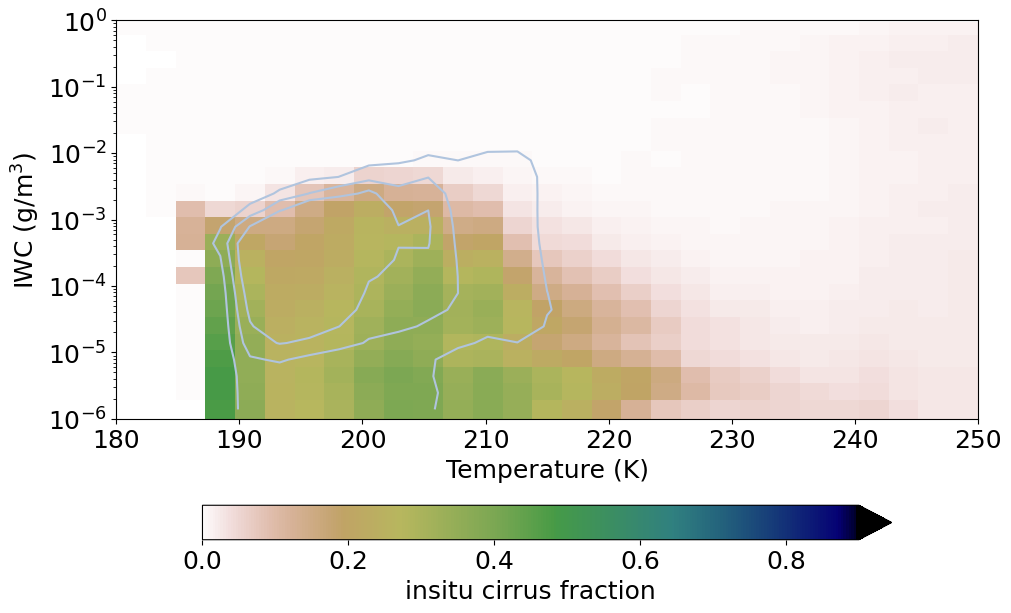

In [10]:
print("plotting... ", end="")
fig, ax = plt.subplots(1, 1, figsize=(10,6), constrained_layout=True)

n = hist.sum().values
hist = hist.where(hist>0)/n
cf = ax.pcolormesh(xbins, ybins, (insitu_frac).T, cmap="gist_earth_r",
                   shading='auto', vmin=0, vmax=0.9)
cs = ax.contour(xbins, ybins, (hist).T, colors='lightsteelblue',
                 levels=np.arange(0,0.008,0.002)
                 )
ax.set(yscale='log', ylim=[1e-6,1], xlim=[180,250])
ax.set(xlabel="Temperature (K)", ylabel="IWC (g/m$^3$)")
# plt.colorbar(cf, ax=ax, label="pdf", location="bottom", shrink=0.8, extend='max')
plt.colorbar(cf, ax=ax, label="insitu cirrus fraction", location="bottom", shrink=0.8, extend='max')

# ax.annotate(n, xy=(0.01,0.92), xycoords="axes fraction", size=16)
savename = f"../plots/large/kramer_IWC-T_histogram_run_{run}_{stat}_{var}.png"
plt.savefig(savename, dpi=120)
print(f"saved as {savename}")
plt.show()

# plot one run micro-hist

In [5]:
####################################################################
# plot 1 run
####################################################################

# file = run_dir + f"{run}_h0_last5days.nc"
print(file)
ds = xr.open_dataset(file, chunks=chunks)[["T","CLDICE","NUMICE","Q"]].isel(time=slice(-16,-1))
# bcu = xr.open_dataset(run_dir+f"{run}_BCU_hrs.nc", chunks=chunks)['BCU'].sel(time=ds.time, method="nearest")
# nuc = xr.open_dataset(run_dir+f"{run}_NUC_hrs.nc", chunks=chunks)['NUC'].sel(time=ds.time, method="nearest")
print("getting t<-40 and cldice>qsmall...")
ds = ds.where((ds["T"]<233.15)&(ds.CLDICE>qsmall))
# nuc = nuc.where((ds["T"]<233.15)&(ds.CLDICE>qsmall))
# ds = ds.where((nuc==0))  # &(bcu<50))  # .compute()
print(ds.Q.shape)
ds.CLDICE

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_d_lpls304k_wbranch/run/dpscream_rce_large_3km_d_lpls304k_wbranch.eam.h0.2000-02-20-10800.nc
getting t<-40 and cldice>qsmall...
(15, 128, 147456)


<xarray.DataArray 'CLDICE' (time: 15, lev: 128, ncol: 147456)> Size: 1GB
dask.array<where, shape=(15, 128, 147456), dtype=float32, chunksize=(15, 128, 100000), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
  * time     (time) object 120B 2000-02-23 03:00:00 ... 2000-02-24 21:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         1
    units:         kg/kg
    mixing_ratio:  wet
    long_name:     Grid box averaged cloud ice amount
    cell_methods:  time: point

In [6]:
print("calc Rice...")
# x_array = np.cbrt(3*ds.CLDICE/(4*np.pi*920.0*ds.NUMICE))
# x_array = x_array * 1e6
x_array = util.calc_rice(ds.CLDICE, ds.NUMICE)
print(x_array.shape)


calc Rice...
(15, 128, 147456)


In [7]:
print("calc NI...")
y_array = util.calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds["T"])
print(y_array.shape)

calc NI...
(15, 128, 147456)


In [8]:
print("flattening...")
x_array = x_array.values.flatten()
print("x done...")
y_array = y_array.values.flatten()
print("y done...")


flattening...
[########################################] | 100% Completed | 21.12 s
x done...
[########################################] | 100% Completed | 33.79 s
y done...


In [9]:
n = len(x_array)
print(n)
n = np.nansum(~np.isnan(x_array))
print(n)

283115520
20463724


In [10]:
xbins=np.linspace(0,100,100)
ybins=np.logspace(-5,2,70)
stat='count'

hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None,
                                                  statistic=stat,
                                                  bins=[xbins,ybins])
print("got count...")

got count...


In [11]:
hist

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [75., 58., 66., ...,  0.,  0.,  0.],
       [64., 45., 46., ...,  0.,  0.,  0.],
       [53., 49., 47., ...,  0.,  0.,  0.]])

In [12]:
xbins = (xbins[1:]+xbins[:-1])/2
ybins = (ybins[1:]+ybins[:-1])/2

In [13]:
da = xr.DataArray(hist, dims=["rice_bins","icnc_bins"],
                  coords={"rice_bins":xbins, "icnc_bins":ybins},
                  attrs={"long_name":f"counts of rice vs icnc for {run}",
                         "n":str(n)})
ds = xr.Dataset({"hist2d":da}, attrs=da.attrs)
print(ds)

ds.to_netcdf(f"../stats/mhist2d_count_{run}_last5days.nc")

<xarray.Dataset> Size: 56kB
Dimensions:    (rice_bins: 99, icnc_bins: 69)
Coordinates:
  * rice_bins  (rice_bins) float64 792B 0.5051 1.515 2.525 ... 97.47 98.48 99.49
  * icnc_bins  (icnc_bins) float64 552B 1.132e-05 1.429e-05 ... 70.92 89.58
Data variables:
    hist2d     (rice_bins, icnc_bins) float64 55kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    long_name:  counts of rice vs icnc for dpscream_rce_large_3km_d_lpls304k_...
    n:          20463724


In [14]:
ds = xr.open_dataset(f"../stats/mhist2d_count_{run}_last5days.nc")
hist = ds.hist2d
xbins = ds.rice_bins
ybins = ds.icnc_bins
n = int(ds.attrs['n'])
stat = 'count'

In [15]:
hist = np.where(hist>0,hist,np.nan)
print("got non-zero values...")
hist = hist/n
print("normalized...")
print(np.nansum(hist),stat,end="")

got non-zero values...
normalized...
0.9901507663023601 count

plotting... ../plots/large/micro_hist_run_dpscream_rce_large_3km_d_lpls304k_wbranch_count.png


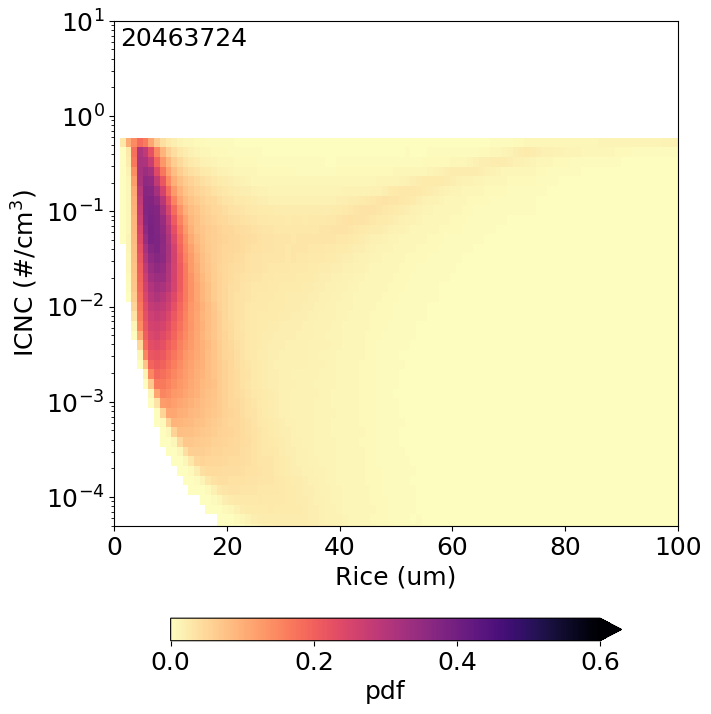

In [16]:
print("plotting... ", end="")
fig, ax = plt.subplots(1, 1, figsize=(7,7), constrained_layout=True)
cf = ax.pcolormesh(xbins, ybins, (hist*100).T, cmap="magma_r",
                      shading='auto',
                      # levels=[0,1,2,4,8,16,32,48]
                      vmin = 0, vmax=0.6 #0.02, 0.3 std
                     )
ax.set(yscale='log')
ax.set(xlim=[0,100], ylim=[5e-5,10])
ax.set(ylabel="ICNC (#/cm$^3$)", xlabel="Rice (um)")
ax.annotate(n, xy=(0.01,0.95), xycoords="axes fraction")
plt.colorbar(cf, ax=ax, label="pdf", location="bottom",
             shrink=0.8, extend='max')
savename=f"../plots/large/micro_hist_run_{run}_{stat}.png"
print(savename)
plt.savefig(savename, dpi=120)
plt.show()

# plot mhist from saved nc file for difference plot

In [5]:
run1="dpscream_rce_large_3km_b_lpls300k_wbranch"
run2="dpscream_rce_large_3km_lpls304k"

In [13]:
file1 = f"../stats/mhist2d_count_{run1}_last5days.nc"
file2 = f"../stats/mhist2d_count_{run2}_last5days.nc"
print(file1, file2)
hist1 = xr.open_dataset(file1)
rice_bins = hist1.rice_bins
icnc_bins = hist1.icnc_bins
n1 = int(hist1.attrs['n'])
hist1 = hist1.hist2d.where(hist1.hist2d>0)/n1
hist2 = xr.open_dataset(file2)
n2 = int(hist2.attrs['n'])
hist2 = hist2.hist2d.where(hist2.hist2d>0)/n2
histd = hist1.where(~np.isnan(hist1),other=0)-hist2.where(~np.isnan(hist2),other=0)
print(hist1.shape, hist2.shape, histd.shape)

../stats/mhist2d_count_dpscream_rce_large_3km_b_lpls300k_wbranch_last5days.nc ../stats/mhist2d_count_dpscream_rce_large_3km_lpls304k_last5days.nc
(99, 69) (99, 69) (99, 69)


plotting... 
../plots/large/micro_hist_run_dpscream_rce_large_3km_b_lpls300k_wbranch-dpscream_rce_large_3km_lpls304k_difference.png


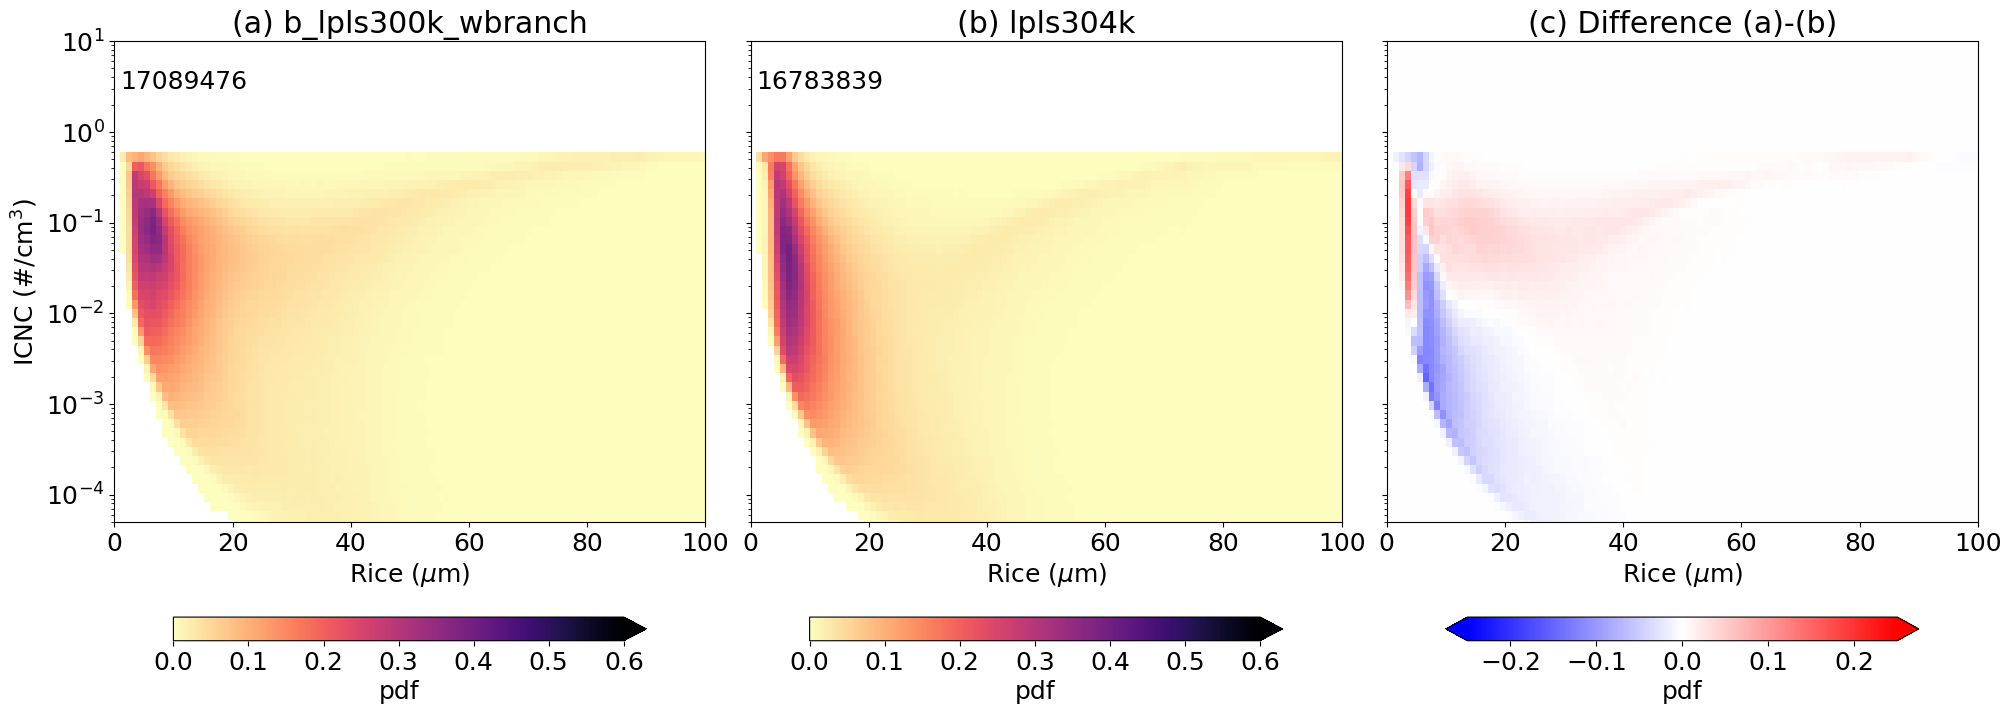

In [15]:
print("plotting... ")
fig, ax = plt.subplots(1, 3, figsize=(20,7), constrained_layout=True,
                       sharex=True, sharey=True)
cf = ax[0].pcolormesh(rice_bins, icnc_bins, (hist1*100).T, cmap="magma_r",
                      shading='auto', vmin=0, vmax=0.6)
ax[0].annotate(n1, xy=(0.01,0.9), xycoords="axes fraction")
plt.colorbar(cf, ax=ax[0], label="pdf", location="bottom",
             shrink=0.8, extend='max')
cf = ax[1].pcolormesh(rice_bins, icnc_bins, (hist2*100).T, cmap="magma_r",
                      shading='auto', vmin=0, vmax=0.6)
ax[1].annotate(n2, xy=(0.01,0.9), xycoords="axes fraction")
plt.colorbar(cf, ax=ax[1], label="pdf", location="bottom",
             shrink=0.8, extend='max')
cf = ax[2].pcolormesh(rice_bins, icnc_bins, (histd*100).T, cmap="bwr",
                      shading='auto', vmin=-0.25, vmax=0.25)
plt.colorbar(cf, ax=ax[2], label="pdf", location="bottom",
             shrink=0.8, extend='both')

ax[0].set(yscale='log', xlim=[0,100], ylim=[5e-5,10], ylabel="ICNC (#/cm$^3$)")
for i in range(3):
    ax[i].set(xlabel="Rice ($\mu$m)")
ax[0].set(title="(a) "+run1[23:])
ax[1].set(title="(b) "+run2[23:])
ax[2].set(title="(c) Difference (a)-(b)")
savename=f"../plots/large/micro_hist_run_{(run1)}-{(run2)}_difference.png"
print(savename)
plt.savefig(savename, dpi=120)
plt.show()

# plot w and ni tracers as mean values in this phase space

In [17]:
file = run_dir + f"{run}_h0_last5days.nc"
var="W_NUC"
var_file = run_dir+f"{run}_{var}_hrs.nc"
print(file, var_file)
ds = xr.open_dataset(file, chunks=chunks)[["T","CLDICE","NUMICE","Q"]].isel(time=slice(-10,-1))
nuc = xr.open_dataset(run_dir+f"{run}_NUC_hrs.nc")['NUC'].isel(time=slice(-10,-1))
var_ds = xr.open_dataset(var_file)[var].isel(time=slice(-10,-1))
print("getting t<-40 and cldice>qsmall...")
ds = ds.where((ds["T"]<233.15)&(ds.CLDICE>qsmall))
var_ds = var_ds.where((ds["T"]<233.15)&(ds.CLDICE>qsmall))
var_ds = var_ds.where(nuc<6)
var_ds = var_ds.compute()
print("done.", var_ds.shape)
var_ds

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_lpfrz300k_branch/run/dpscream_rce_large_3km_lpfrz300k_branch_h0_last5days.nc /glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_lpfrz300k_branch/run/dpscream_rce_large_3km_lpfrz300k_branch_W_NUC_hrs.nc
getting t<-40 and cldice>qsmall...
[########################################] | 100% Completed | 171.94 s
[########################################] | 100% Completed | 171.96 s
done. (9, 128, 147456)


<xarray.DataArray 'W_NUC' (time: 9, lev: 128, ncol: 147456)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) object 2000-02-27 18:00:00 ... 2000-03-01 18:00:00
  * lev      (lev) float64 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: ncol
Attributes:
    long_name:     W at nucleation
    units:         kg/kg
    mdims:         1
    mixing_ratio:  dry
    cell_methods:  time: point

In [18]:
var_ds.max().values

array(7.84557772)

In [ ]:
hist, edges = np.histogram(var_ds.values.flatten(), bins=-np.logspace(-4,1,20))
hist

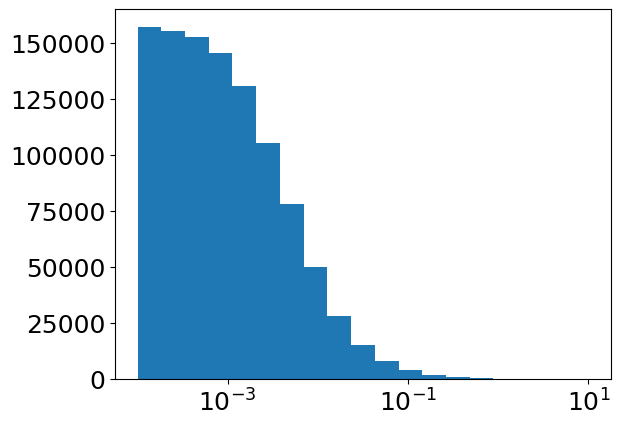

In [35]:
fig, ax = plt.subplots(1,1)
ax.bar(edges[:-1], hist, align='edge', width=(edges[1:]-edges[:-1]))
ax.set(xscale='log', 
       # yscale='log',
       # ylim=[1,1e4],
      )
plt.show()